In [41]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt


%matplotlib inline

In [74]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [75]:
len(words)

32033

In [76]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [77]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words[:]:
    # print(w)
    context = [0] * block_size

    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [78]:
def build_dataset(_words):
    block_size = 3
    X, Y = [], []
    for w in _words[:]:
        # print(w)
        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
C = torch.randn((27, 2))  # embed 27 characters in a 2-dim vector space
# essentially, if there is a 2-dim space, then each one of the 27 chars can be represented as a point in that space.

In [7]:
emb = C[X]  # embeddings of individual starting data points

In [11]:
# construct hidden layer.
# 6 - inputs cuz 3 * 2 -> 3 of 2-dim embeddings
W1 = torch.randn((6, 100))  # 100 neurons for the layer
b1 = torch.randn(100)

In [17]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [19]:
h.shape

torch.Size([32, 100])

In [21]:
# output layer

W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [22]:
logits = h @ W2 + b2

In [24]:
counts = logits.exp()

In [25]:
prob = counts / counts.sum(1, keepdims=True)

In [26]:
prob.shape

torch.Size([32, 27])

In [29]:
loss = -prob[torch.arange(32), Y].log().mean()

In [30]:
loss

tensor(14.1654)

In [31]:
# rearrange

In [99]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [100]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)  # embed 27 characters in a 2-dim vector space

# increase layer size from 100 to 300

W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [101]:
sum(p.nelement() for p in parameters)

10281

In [102]:
for p in parameters:
    p.requires_grad = True

In [103]:
# learning rate exponent
lre = torch.linspace(-3, 0, 1000)  # between .001 & 1
lrs = 10**lre

In [132]:
# forward pass
lri = []
lossi = []
stepi = []

for i in range(30000):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2

    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = prob[torch.arange(32, Y)]

    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.05
    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)

print(loss.item())

2.197427272796631


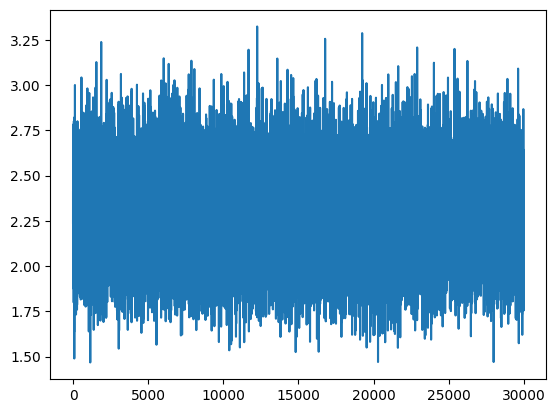

In [133]:
plt.plot(stepi, lossi)

In [134]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2717, grad_fn=<NllLossBackward0>)

In [135]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

# the train & dev losses are approx equal, since the model is small, this is a case of underfitting.

tensor(2.2594, grad_fn=<NllLossBackward0>)

In [ ]:
# train, dev/validate, test splits
# 80%, 10%, 10%
# (hyperparameters: the NN has a few settings like, number of neurons, size of the embeddings,
#  number of layers, lambda value for regularisation loss)
# (parameters are the components of the model itself. the weights & biases in this case)
# train: optmise the parameters of the model
# dev: determine the combination of the hyperparameters
# test: perf of the model. use very very sparingly, otherwise overfitting can happen, cuz feedback on perf here bleeds into training

In [ ]:
# visualise the embedding